# Exam paper: Optimal Energy mix in Greenland
### _Group 1: Marie Louise, Sofie & Caroline_

We import the basic packages:

In [1]:
%run stdPackages.ipynb

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from pyDbs import *
from IPython.display import Image
figs_path = os.path.join(d['curr'],'Figs')


We create a path to data

In [43]:
import os 
path_to_data = os.path.join(d['curr'],'Data','E44_Data-ny.xlsx')
print(path_to_data)

c:\Users\CAAL\OneDrive - COWI\Desktop\Nuuk-Energy-mix\Exercises\E44\Data\E44_Data-ny.xlsx


In [44]:
kwargs = {'variables': ['Fundamentals', 'Load', 'Generators_Other'],
        'maps': ['Generators_Categories','hMaps'],
        'variable2D': ['HourlyVariation','Generators_FuelMix', 'Rainfall'],
        'scalars': ['Scalars']}

db = read.dbFromWB(path_to_data, kwargs)
readSets(db)

Finally, make sure your code is correct by solving for the baseline scenario, where this is no storage:

In [7]:
from Exam import *
m = mSimple(db)
m()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


__Control__

We control if we leave _charge_ out of the model, since we set it exogeniously

In [8]:
m.db.symbols.keys()

dict_keys(['FuelPrice', 'EmissionIntensity', 'EmissionTax', 'LoadVariation', 'Load', 'OtherMC', 'effS', 'GeneratingCapacity', 'sCap', 'id2tech', 'id2hvt', 'h2Week', 'h2HourOfTheDay', 'h2Month', 'h2Weekday', 'CapVariation', 'FuelMix', 'Rainfall', 'MWP', 'BFt', 'EmissionType', 'c', 'h', 'id', 'hvt', 'h_constr', 'id_constr', 'mc', 'Generation', 'discharge', 'HourlyDemand', 'stored', 'λ_LawOfMotion', 'λ_equilibrium', 'λ_Generation', 'λ_discharge', 'λ_HourlyDemand', 'λ_stored', 'Welfare', 'meanConsumerPrice', 'capacityFactor', 'marginalSystemCosts', 'marginalEconomicValue', 'capturePrice', 'marketValueFactor', 'consumerSurplus', 'producerSurplus'])

Save solution for later:

In [9]:
base_db = m.db.copy()

In the following, we aggregate the fuel types to the following types:

In [10]:
agg_BFt = {
    'Fueloil':'Oil','Gasoil':'Oil', 
    'Straw':'Biomass','WoodPellets':'Biomass','WoodChips':'Biomass','WoodWaste':'Biomass',
    'Biogas':'Other Bio','BioOil':'Other Bio',
    'Coal':'Coal',
    'NatGas':'Natural gas',
    'Waste':'Waste'
}

### __Descriptives__

Text(0.5, 1.0, 'Hourly demand in electricity')

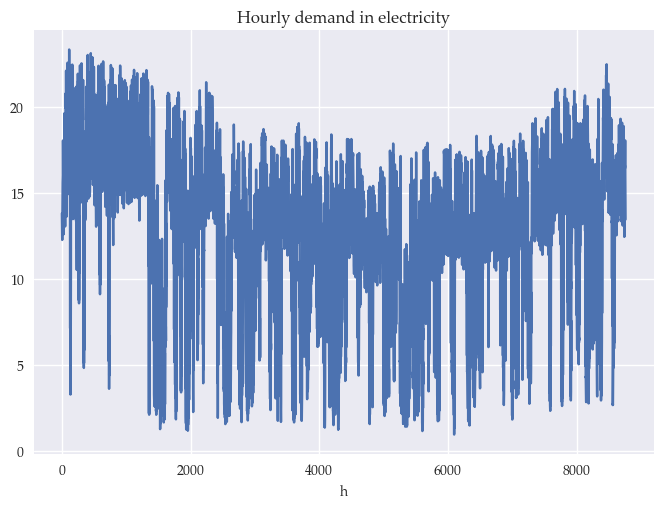

In [30]:
m.db['HourlyDemand']['c1', :].plot()
plt.title('Hourly demand in electricity')

# The optimal combination of wind and hydro

First, we define the vectors. 

Since Buksefjordsværket in Nuuk already has a capacity of 45 mW, and the planned expantion of the hydro power plant is 55 mW (in all 100 mW), the vector of hydro goes from 45 to 100. 

Thus, the vector of wind goes from 0 to 55 mW. 

Each vector contains five points, and so we have 25 combinations of hydro and wind.

In [49]:
# Defining vectors for wind and hydro
vec_hydro = np.linspace(45, 100, 5)
vec_wind = np.linspace(0, 55, 5)

# printing vectors
print("Vector for hydro:", vec_hydro)
print("Vector for wind:", vec_wind)



Vector for hydro: [ 45.    58.75  72.5   86.25 100.  ]
Vector for wind: [ 0.   13.75 27.5  41.25 55.  ]


### __Electricity__

Secondly, we create two dataframes representing electricity capacity of hydro and wind, respectively. 

In [50]:
# defining of minimum electricity
min_elec = [vec_hydro[0], vec_wind[0]]

# definition of max electricity
max_elec = [vec_hydro[4], vec_wind[4]]

# Defining the loop
loop = pd.RangeIndex(25)

# lower and upper bound for hydro
v0_ECap_Hydro = pd.Series(min_elec[0], index=getTechs(['Storage'], m.db))
vT_ECap_Hydro = pd.Series(max_elec[0], index=getTechs(['Storage'], m.db))

# Grid for hydro
grid_ECap_Hydro = pd.Series([vec_hydro[i] for i in range(5) for _ in range(5)], index=loop)

# lower and upper bound for wind
v0_ECap_Wind = pd.Series(min_elec[1], index=getTechs(['Standard'], m.db))
vT_ECap_Wind = pd.Series(max_elec[1], index=getTechs(['Standard'], m.db))

# grid for wind
grid_ECap_Wind = pd.Series([vec_wind[i] for _ in range(5) for i in range(5)], index=loop)


In [55]:
grid_ECap_Wind

0      0.00
1     13.75
2     27.50
3     41.25
4     55.00
5      0.00
6     13.75
7     27.50
8     41.25
9     55.00
10     0.00
11    13.75
12    27.50
13    41.25
14    55.00
15     0.00
16    13.75
17    27.50
18    41.25
19    55.00
20     0.00
21    13.75
22    27.50
23    41.25
24    55.00
dtype: float64

### __Storage__

Third, we create a dataframe representing storage capacity based on the reservior of the hydro power plant

In [13]:
# The "energy storage to power"-ratio/storage duration 
E2P = 5000

# Defining min storage
min_storage = vec_hydro[0]

# defining max storage
max_storage = vec_hydro[4]

# Defining a storage vector
vec_storage = np.linspace(min_storage, max_storage, 5)*E2P

# defining lower and upper bound for electricity storage by multiplying E2P with the energy production
v0_SCap = pd.Series(min_storage, index = getTechs(['Storage'], m.db))*E2P
vT_SCap = pd.Series(max_storage, index = v0_SCap.index)*E2P

# Second grid with a storage cap running through loop 2
grid_SCap = pd.Series([vec_storage[i] for i in range(5) for _ in range(5)], index=loop)

In [47]:
grid_SCap

0     225000.0
1     225000.0
2     225000.0
3     225000.0
4     225000.0
5     293750.0
6     293750.0
7     293750.0
8     293750.0
9     293750.0
10    362500.0
11    362500.0
12    362500.0
13    362500.0
14    362500.0
15    431250.0
16    431250.0
17    431250.0
18    431250.0
19    431250.0
20    500000.0
21    500000.0
22    500000.0
23    500000.0
24    500000.0
dtype: float64

### __Solving the model__

Then, we extract the relevant variables to solve the model:

In [56]:
extract = ['marginalSystemCosts','Generation', 'discharge','capturePrice','marketValueFactor','capacityFactor','marginalEconomicValue','consumerSurplus','producerSurplus','Welfare']

And finally, we solve the model:

In [75]:
solution = m.loopSolveExtract(loop, [grid_ECap_Wind, grid_ECap_Hydro, grid_SCap], extract)

### __Results__

In [76]:
solution['Welfare']

0     5.764832e+06
1     5.764832e+06
2     5.764832e+06
3     5.764832e+06
4     5.764832e+06
5     5.764832e+06
6     5.764832e+06
7     5.764832e+06
8     5.764832e+06
9     5.764832e+06
10    5.764832e+06
11    5.764832e+06
12    5.764832e+06
13    5.764832e+06
14    5.764832e+06
15    5.764832e+06
16    5.764832e+06
17    5.764832e+06
18    5.764832e+06
19    5.764832e+06
20    5.764832e+06
21    5.764832e+06
22    5.764832e+06
23    5.764832e+06
24    5.764832e+06
dtype: float64

# Random things

Third, we define a grid with two dimentions, so that the grid contains both electricity generation from hydro and wind

In [ ]:
def grid(vec_hydro, vec_wind, index, gridtype='linear', phi=1): 

    if gridtype == 'linear': # If v0, vT are one dimentional numpy arrays, returns two dimentional array. 
        return np.linspace(vec_hydro, vec_wind, len(index)) 
      
    elif gridtype=='polynomial': # If scalars, returns one dimentional arrays.
        return np.array([vec_hydro+(vec_wind-vec_hydro)*((i-1)/(len(index)-1))**phi for i in range(1,len(index)+1)])

In [ ]:
def addGrid(vec_hydro, vec_wind, index, name, gridtype = 'linear', phi = 1, sort_levels=None, sort_index = False): # NB: Make sure that v0 and vT are sorted similarly (if they are defined over indices)
    
    if sort_index:
        vec_hydro = vec_hydro.sort_index()
        vec_wind = vec_wind.sort_index()

    if isinstance(vec_hydro, pd.Series):
        return pd.DataFrame(grid(vec_hydro, vec_wind, index, gridtype=gridtype, phi=phi).T, index = vec_hydro.index, columns = index).stack().rename(name).reorder_levels(index.names+vec_wind.index.names if sort_levels is None else sort_levels)
    
    else:
        return pd.Series(grid(vec_hydro, vec_wind, index, gridtype=gridtype, phi=phi), index=index, name=name)

Then, we converge the vectors into flat indexs 

In [ ]:
import lpCompiler

In [ ]:
df_E = lpCompiler.sortAll(addGrid(grid_ECap, grid_ECap, loop_wind, 'GeneratingCap_E').unstack('id'))
df_S = lpCompiler.sortAll(addGrid(grid_SCap, grid_SCap, loop_hydro, 'sCap').unstack('id'))

# redefining the name of the loops
df_E.index = df_E.index.to_flat_index().rename('loop')
df_S.index = df_S.index.to_flat_index().rename('loop')

# 
grid_ECap_1d = df_E.stack().rename('GenerationCapacity')
grid_SCap_1d = df_S.stack().rename('GenerationCapacity')

# Defining the loop as an index
loop = df_E.index

In [ ]:
df_E

id,idES,id6
loop,,
"(0, 0)",45.0,0.0
"(0, 1)",45.0,0.0
"(0, 2)",45.0,0.0
"(0, 3)",45.0,0.0
"(0, 4)",45.0,0.0
"(1, 0)",58.0,13.0
"(1, 1)",58.0,13.0
"(1, 2)",58.0,13.0
"(1, 3)",58.0,13.0


Then, we extract the following variables:

Vi har desuden fjernet alle emmissionsvariable, da vi kun har VE-anlæg

Her tilføjes en ekstra variable, da storage muligheden også udvider sig grundet udvidelse af vandkraftværk. Derfor tager det også længere tid at tømme reservioret. Man kan se, at de følges ad --> så reservioret ikke tømmes hurtigere pga. udvidelse heraf men tværdigmod

In [ ]:
grid_SCap_1d2 = (grid_SCap_1d*5000).rename('SCap')

In [34]:
m.db['Generation'][:, 'id6']

h
1       13.820385
2       13.392084
3       12.850539
4       12.531986
5       12.292986
          ...    
8756    15.981571
8757    14.761723
8758    14.641821
8759    14.080541
8760    13.468162
Length: 8760, dtype: float64

In [39]:
m.hourlyGeneratingCap['id6'][m.hourlyGeneratingCap['id6'] - m.db['HourlyDemand']['c1', :] < 0].sum()

17792.691162259584

In [40]:
m.hourlyGeneratingCap['idES'][m.hourlyGeneratingCap['idES']].sum()

876000

In [ ]:
m.globalDomains['LawOfMotion']

MultiIndex([('idES',    1),
            ('idES',    2),
            ('idES',    3),
            ('idES',    4),
            ('idES',    5),
            ('idES',    6),
            ('idES',    7),
            ('idES',    8),
            ('idES',    9),
            ('idES',   10),
            ...
            ('idES', 8751),
            ('idES', 8752),
            ('idES', 8753),
            ('idES', 8754),
            ('idES', 8755),
            ('idES', 8756),
            ('idES', 8757),
            ('idES', 8758),
            ('idES', 8759),
            ('idES', 8760)],
           names=['id_constr', 'h_constr'], length=8760)

<Axes: xlabel='h'>

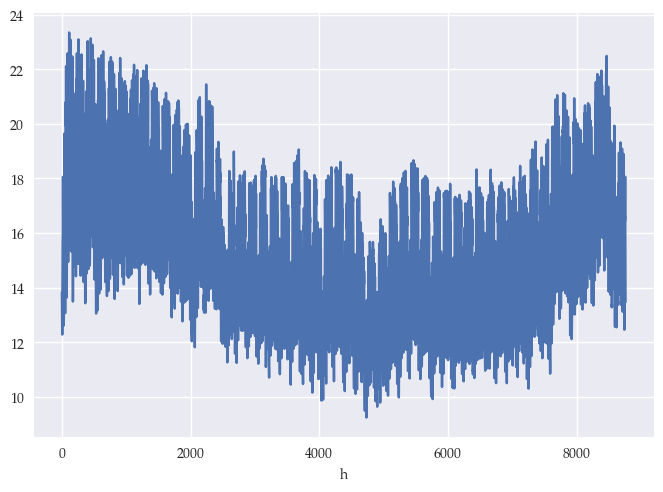

In [ ]:
m.db['HourlyDemand']['c1', :].plot()

In [ ]:
solution['charge'][:,:,0][solution['charge'][:, :, 0] > 0]

Series([], dtype: float64)

In [18]:
solution['Welfare']

0     5.764832e+06
1     5.764832e+06
2     5.764832e+06
3     5.764832e+06
4     5.764832e+06
5     5.764832e+06
6     5.764832e+06
7     5.764832e+06
8     5.764832e+06
9     5.764832e+06
10    5.764832e+06
11    5.764832e+06
12    5.764832e+06
13    5.764832e+06
14    5.764832e+06
15    5.764832e+06
16    5.764832e+06
17    5.764832e+06
18    5.764832e+06
19    5.764832e+06
20    5.764832e+06
21    5.764832e+06
22    5.764832e+06
23    5.764832e+06
24    5.764832e+06
dtype: float64

<Axes: xlabel='h'>

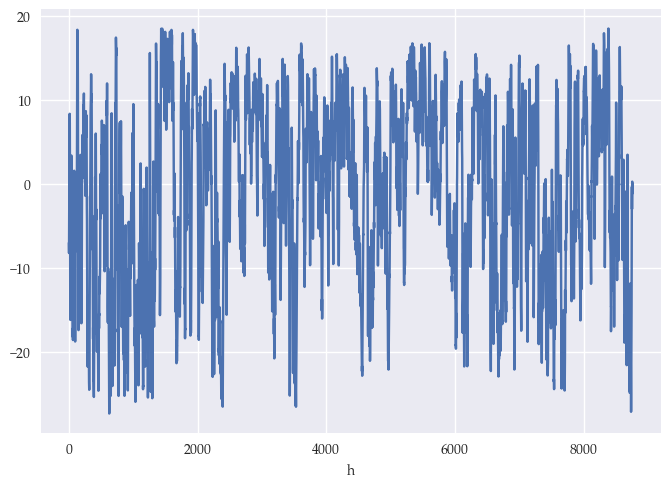

In [ ]:
(m.hourlyLoad - m.hourlyGeneratingCap.xs('id6')).plot()

In [ ]:
# bør være 0, da vi arbejder med vandreservior og ikke tilbagefører vandet
solution['charge'].loc[:, 'idES', (2,2)]

h
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
       ... 
8756    0.0
8757    0.0
8758    0.0
8759    0.0
8760    0.0
Length: 8760, dtype: float64

In [ ]:
# bør altid være positiv, da vi har en minimum værdi af 45 MW
solution['discharge'].loc[:, 'idES', (2,2)]

h
1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
          ...   
8756    0.000000
8757    0.000000
8758    0.000000
8759    0.008391
8760    0.000000
Length: 8760, dtype: float64

# Appendix

The table below translates the names used in the data to the symbols used in the model. 

| Name in excel file | Model symbol |
|:--------|:--------:|
| id | $i$ | 
| BFt | $j$ |
| h | $h$ |
|  FuelMix   |  $\mu_{i,j}$   |
|  GeneratingCapacity   | $q_i$   |
|  OtherMC   | $c_i^{oth}$   |
| FuelPrice | $p_j^f$ |
| EmissionIntensity | $\phi_j$ |
| MWP | $\mu$ |
| LoadVariation $\times$ Load | $D_h$ |
| CapVariation | $\gamma_{i,h} $ |
| sCap | $\overline{S}_i$ |
| effS | $\sqrt{\eta_i}$ |

Note that $c$ is also an index for the consumer type in the data file. In the model in [**Part 1**](#Part-1:-Analytical-Exercises), however, there is only a single representative consumer. But since $c=c1$ always, this is equivalent.

The following section imports the data: